In [ ]:
# importar paquetes que se van a usar
!pip install yfinance --upgrade --no-cache-dir
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import xarray as xr
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('display.precision', 3)

pd.reset_option('display.notebook_repr_html')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.precision')

In [ ]:
# Descargar datos de Yahoo! finance
# Tickers
tickers = ['AA', 'AAPL', 'MSFT', '^GSPC']
# Fuente
data_source = 'yahoo'
# Fechas: desde 01/01/2022 hasta 12/31/2024
start_date = '2022-01-01'
end_date = '2025-12-31'
# Usar yfinance para descargar los datos y ordenarlos
data = yf.download(tickers, start=start_date, end=end_date)
# ordenar los datos
assets = data.sort_index()
#dataframe a xarray para acceder a los datos como panel
dataset = assets.to_xarray()
# Convierte el DataFrame a un xarray.Dataset con las dimensiones correctas
dataset = assets.stack(level=1).to_xarray()
dataset = dataset.to_array(dim='Attributes')

[*********************100%***********************]  4 of 4 completed
<ipython-input-2-c91c3c1f46cc>:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dataset = assets.stack(level=1).to_xarray()


# 2. Gráficos útiles de los rendimientos

Se calculan los rendimientos de todos los activos considerados. De nuevo, para una sucesión de precios $\{S_t\}^n_{t=0}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$R_t = \frac{S_t - S_{t-1}}{S_{t-1}}$

para $t = 1, ..., n.$

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logarítmico. Se define como:

$r_t = ln(1 + R_t)$

donde $R_t$ es el rendimiento simple. Es fácil darse cuenta que $r_t = ln( \frac{S_t}{S_{t-1}} )$

In [ ]:
allA=assets['Close']
R = ((allA - allA.shift(1))/allA)[1:]
r=np.log(1+R)

In [ ]:
R.describe()

Ticker,AA,AAPL,MSFT,^GSPC
count,757.000000,757.000000,757.000000,757.000000
mean,-0.001267,0.000257,0.000198,0.000217
std,0.035509,0.017002,0.017348,0.011027
min,-0.204016,-0.062338,-0.083607,-0.045190
25%,-0.022101,-0.008528,-0.008587,-0.005814
50%,-0.000520,0.001094,0.000846,0.000251
75%,0.021184,0.009531,0.010518,0.006679
max,0.130769,0.081705,0.076014,0.052523


<Axes: xlabel='Date'>

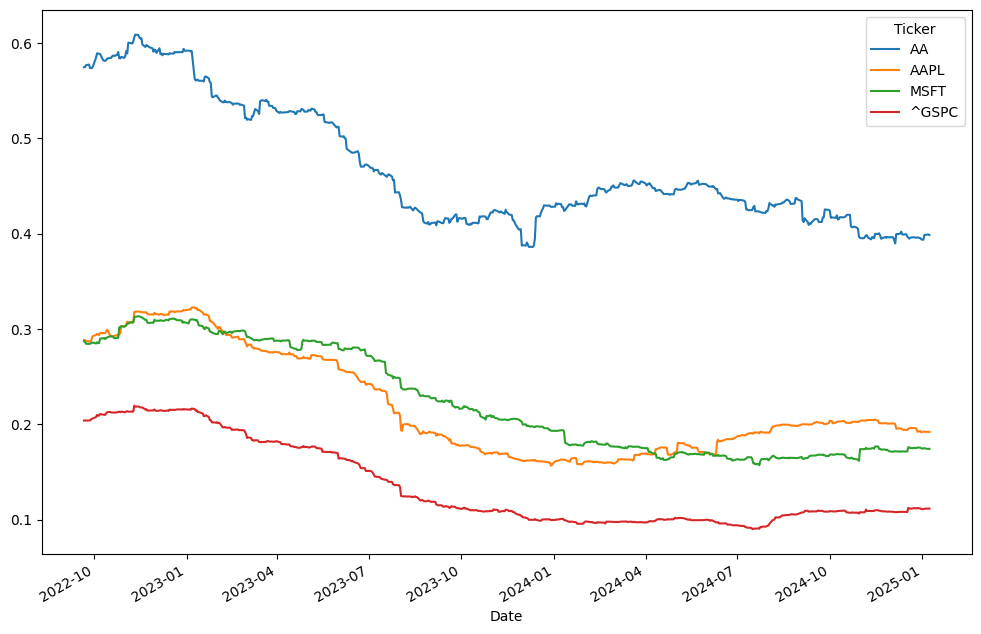

In [ ]:
min_periods = 180
vol = R.rolling(window=min_periods).std()*np.sqrt(min_periods)
vol.plot(figsize=(12,8))

Esta gráfica calcula la volatilidad anualizada de los rendimientos de los activos utilizando una ventana móvil de 180 días. El gráfico muestra cómo cambia la volatilidad a lo largo del tiempo.

<Axes: xlabel='Date'>

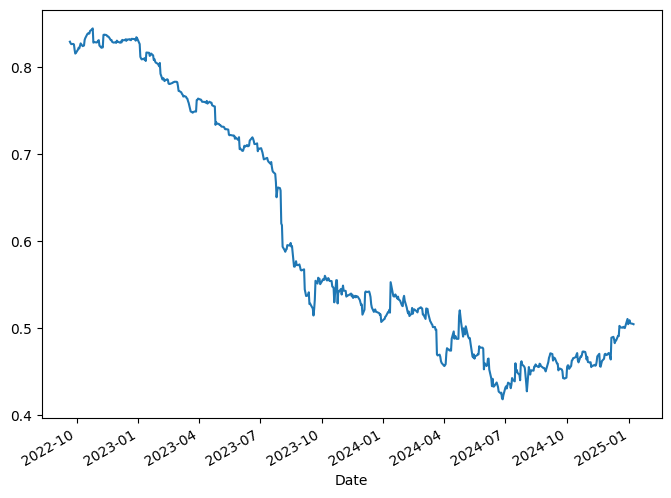

In [ ]:
rolling_corr = R['AAPL'].rolling(window=180).corr(R['MSFT']).dropna()
rolling_corr.plot(figsize=(8,6))

Esta gráfica muestra la correlación de Apple y Microsoft a través del tiempo. Podemos observar que al inicio tienen una relación cercana a 1, por lo tanto, en ese periodo sus rendimientos se movían casi en la misma dirección.
Después, la gráfica desciende y mustra fluctuaciones, lo que indica que su correlación cambia con el tiempo. Esto indica que puede haber periodos donde la correlación es más fuerte o más débil.

<ipython-input-7-e5c99f27b992>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(R['AA'], color="b", fit=stats.norm, norm_hist=True, ax=axes[0, 0])
<ipython-input-7-e5c99f27b992>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(R['AAPL'], color="r", fit=stats.norm, norm_hist=True, ax=axes[0, 1])


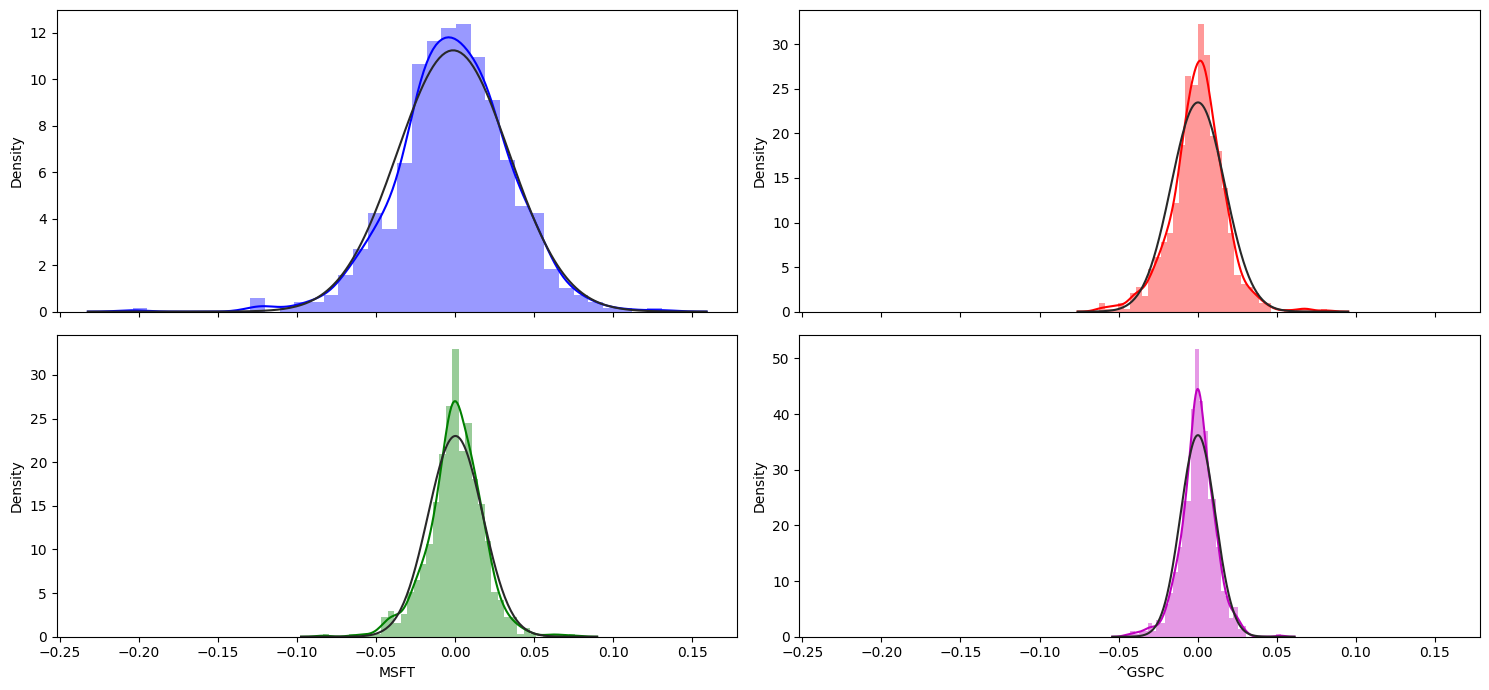

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(15,7), sharex=True)
# Grafica un histograma
sns.distplot(R['AA'], color="b", fit=stats.norm, norm_hist=True, ax=axes[0, 0])
sns.distplot(R['AAPL'], color="r", fit=stats.norm, norm_hist=True, ax=axes[0, 1])
sns.distplot(R['MSFT'], color="g", fit=stats.norm, norm_hist=True, ax=axes[1, 0])
sns.distplot(R['^GSPC'], color="m", fit=stats.norm, norm_hist=True, ax=axes[1, 1])
#Ajustar el espacio entre las subgráficas
plt.subplots_adjust(hspace=2)
plt.tight_layout()

* **Si el histograma es alto y estrecho (picudo)**, sugiere una distribución leptocúrtica con colas delgadas. Los rendimientos tenderán a concentrarse al rededor de la media y es menos probable observar valores extremos.

* **Si el histograma es bajo y ancho (aplastado)**, sugiere una distribución platicúrtica con colas gruesas. Los rendimientos son más dispersos y hay mayor probabilidad de observar valores extremos, tanto positivos como negativos.


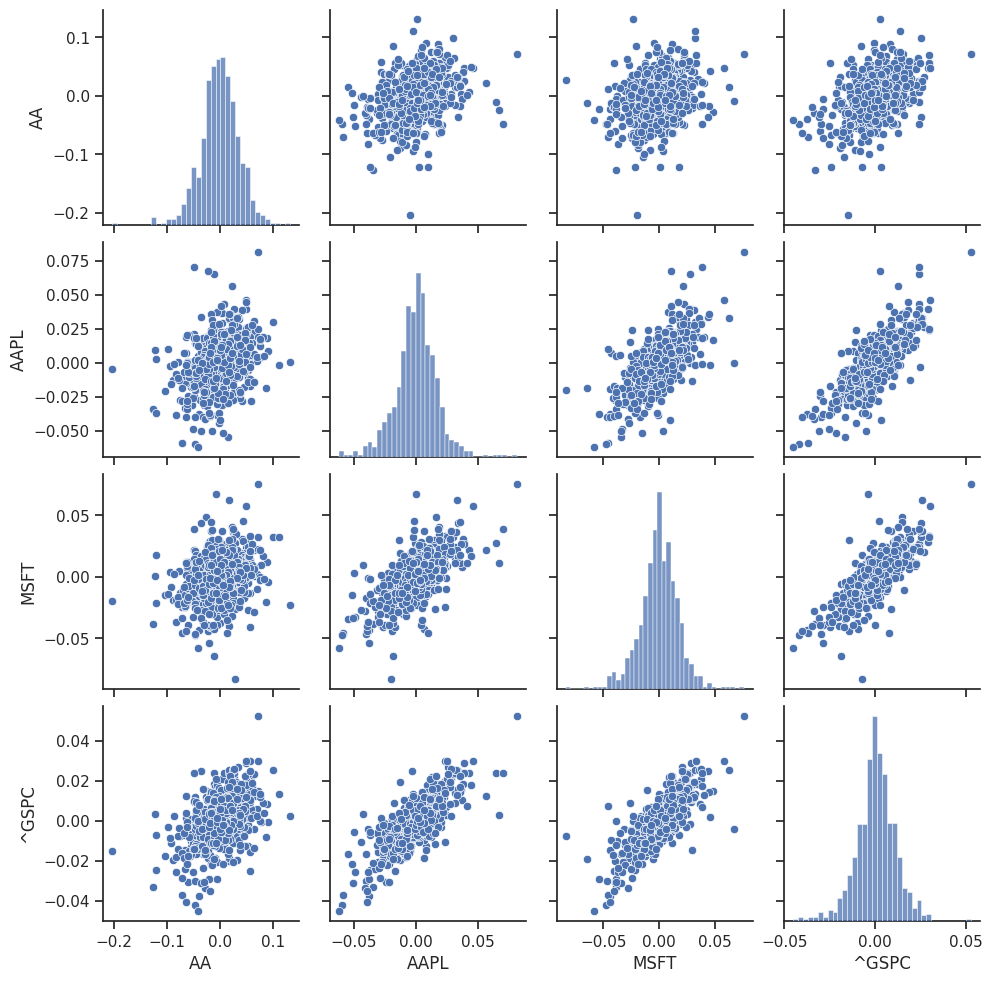

In [ ]:
sns.set(style="ticks")
sns.pairplot(R);

ValueError: Contour levels must be increasing

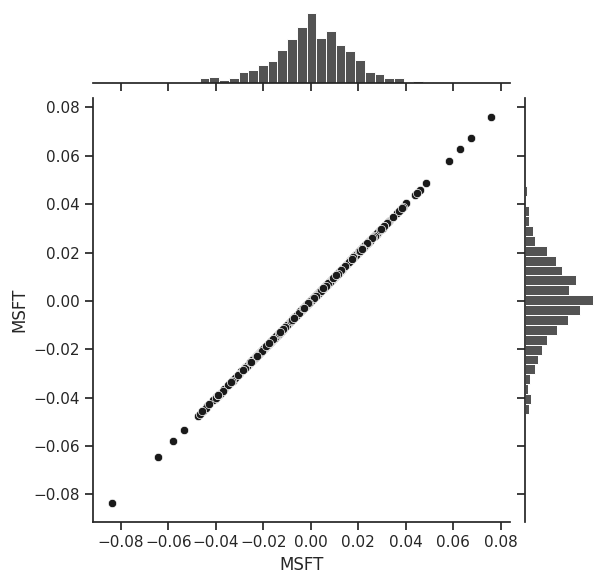

In [ ]:
g = sns.jointplot(x="MSFT", y="MSFT", data=R, color="k")
g.plot_joint(sns.kdeplot, zorder=0, n_levels=60, levels=np.linspace(0, 1, 61))

# Calcular Pearsonr y p
pearsonr, p = stats.pearsonr(R['MSFT'], R['MSFT'])

# Agregar la anotación con los valores
g.ax_joint.annotate(f'Pearsonr = {pearsonr:.2f}\np = {p:.2f}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    fontsize=12)

Text(0.1, 0.9, 'Pearsonr = 0.28\np = 0.00')

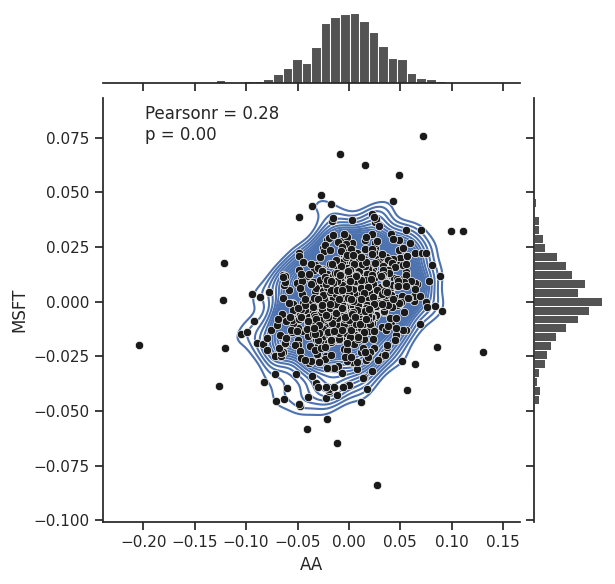

In [ ]:
g = sns.jointplot(x="AA", y="MSFT", data=R, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=60);

# Calcular Pearsonr y p
pearsonr, p = stats.pearsonr(R['AA'], R['MSFT'])

# Agregar la anotación con los valores
g.ax_joint.annotate(f'Pearsonr = {pearsonr:.2f}\np = {p:.2f}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    fontsize=12)

Text(0.1, 0.9, 'Pearsonr = 0.69\np = 0.00')

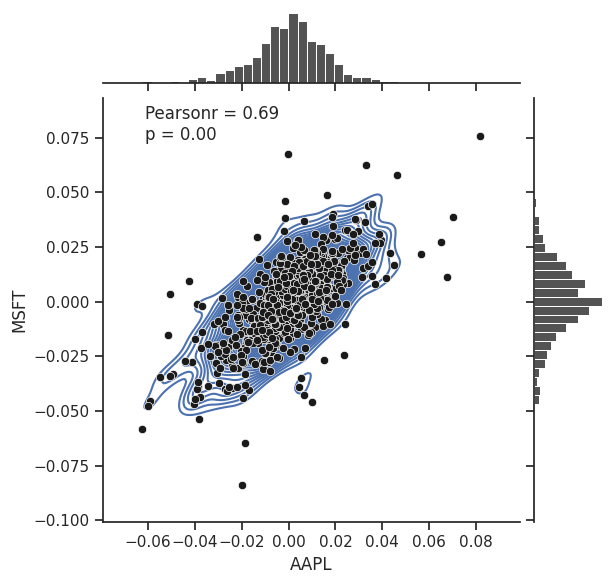

In [ ]:
g = sns.jointplot(x="AAPL", y="MSFT",data=R, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=60);

# Calcular Pearsonr y p
pearsonr, p = stats.pearsonr(R['AAPL'], R['MSFT'])

# Agregar la anotación con los valores
g.ax_joint.annotate(f'Pearsonr = {pearsonr:.2f}\np = {p:.2f}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    fontsize=12)

Text(0.1, 0.9, 'Pearsonr = 0.79\np = 0.00')

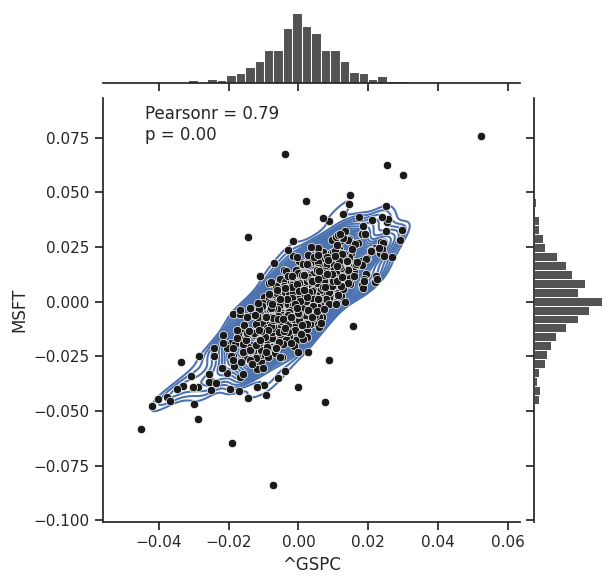

In [ ]:
g = sns.jointplot(x="^GSPC", y="MSFT",data=R, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=60);

# Calcular Pearsonr y p
pearsonr, p = stats.pearsonr(R['^GSPC'], R['MSFT'])

# Agregar la anotación con los valores
g.ax_joint.annotate(f'Pearsonr = {pearsonr:.2f}\np = {p:.2f}',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    fontsize=12)

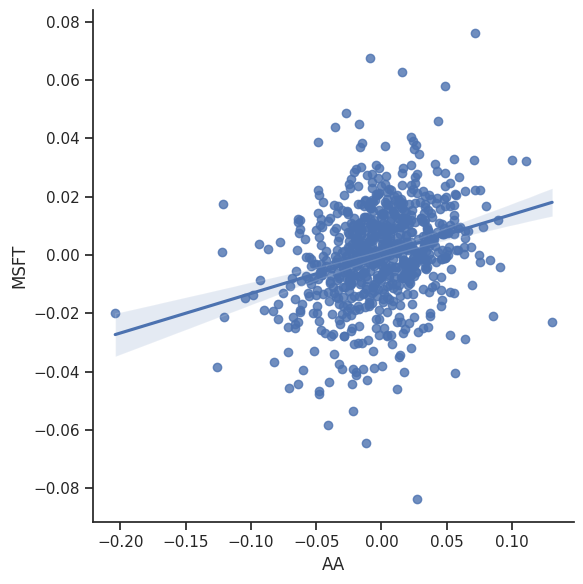

In [ ]:
sns.lmplot(x="AA", y="MSFT", truncate=True, height=6, data=R);

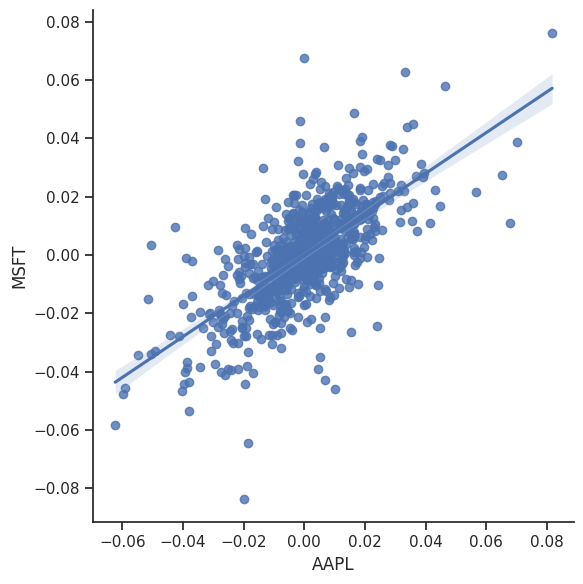

In [ ]:
sns.lmplot(x="AAPL", y="MSFT", truncate=True, height=6, data=R);

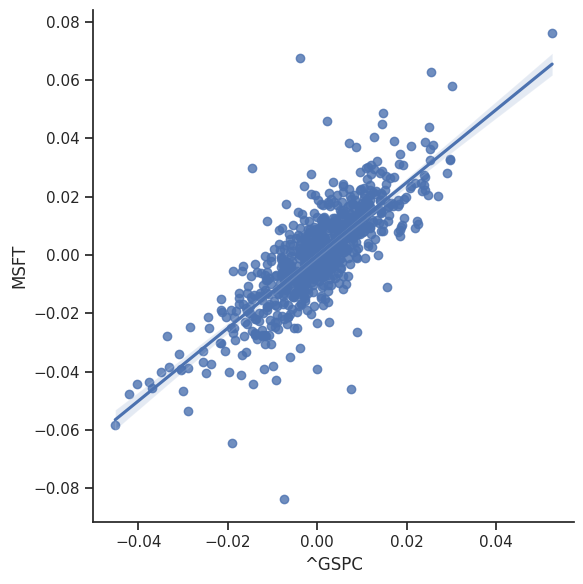

In [ ]:
sns.lmplot(x="^GSPC", y="MSFT", truncate=True, height=6, data=R);

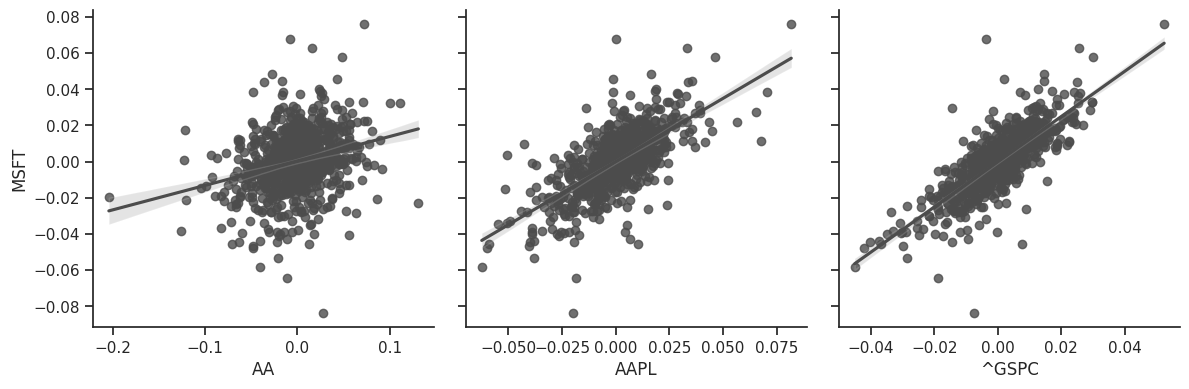

In [ ]:
g = sns.PairGrid(R, y_vars=["MSFT"], x_vars=["AA", "AAPL", "^GSPC"], height=4)
g.map(sns.regplot, color=".3");